# Tutorial: Building deep learning models using eo4wildfires dataset, huggingface's transformers and PyTorch models

Before we proceed, assuming the new Python3 changes, we need to install and activate a virtual environment for the libraries that we are going to use in this tutorial. Please check README.md of this project, for more information. After all libraries are installed, we simply import the eo4wildfires dataset directly from huggingface, during the prompt "Do you wish to run the custom code?" type "y" and press Enter (before typing "y" you should review the dataloading code at https://huggingface.co/datasets/AUA-Informatics-Lab/eo4wildfires/blob/main/eo4wildfires.py).


This should take a moment, depending on your connection. It should begin downloading the zip archive of the dataset and then extract it. After extraction, train/test/validation splits are automatically calculated and converted into pyarrow format, for more efficient loading. Note that only the first time should take a while, after that dataset should load within seconds.

In [1]:
from datasets import load_dataset

dataset = load_dataset('AUA-Informatics-Lab/eo4wildfires')

README.md:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

eo4wildfires.py:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

The repository for AUA-Informatics-Lab/eo4wildfires contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/AUA-Informatics-Lab/eo4wildfires.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


eo4wildfires.tar.gz:   0%|          | 0.00/25.5G [00:00<?, ?B/s]

files_train.csv.gz:   0%|          | 0.00/58.0k [00:00<?, ?B/s]

files_val.csv.gz:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

files_test.csv.gz:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/32 [00:00<?, ?it/s]

Dataset metadata

In [2]:
dataset['train'].info

DatasetInfo(description='Initial Release of eo4wildfires for Huggingface library.', citation='\n    @Article{fire7110374,\n        AUTHOR = {Sykas, Dimitris and Zografakis, Dimitrios and Demestichas, Konstantinos},\n        TITLE = {Deep Learning Approaches for Wildfire Severity Prediction: A Comparative Study of Image Segmentation Networks and Visual Transformers on the EO4WildFires Dataset},\n        JOURNAL = {Fire},\n        VOLUME = {7},\n        YEAR = {2024},\n        NUMBER = {11},\n        ARTICLE-NUMBER = {374},\n        URL = {https://www.mdpi.com/2571-6255/7/11/374},\n        ISSN = {2571-6255},\n        ABSTRACT = {This paper investigates the applicability of deep learning models for predicting the severity of forest wildfires, utilizing an innovative benchmark dataset called EO4WildFires. EO4WildFires integrates multispectral imagery from Sentinel-2, SAR data from Sentinel-1, and meteorological data from NASA Power annotated with EFFIS data for forest fire detection and s

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'S1_GRD_A', 'S1_GRD_D', 'S2A', 'NASA', 'x', 'y', 'total_burned_area', 'burned_mask'],
        num_rows: 31227
    })
    validation: Dataset({
        features: ['id', 'S1_GRD_A', 'S1_GRD_D', 'S2A', 'NASA', 'x', 'y', 'total_burned_area', 'burned_mask'],
        num_rows: 7402
    })
    test: Dataset({
        features: ['id', 'S1_GRD_A', 'S1_GRD_D', 'S2A', 'NASA', 'x', 'y', 'total_burned_area', 'burned_mask'],
        num_rows: 9758
    })
})

In [4]:
# Convert dataset arrays into numpy arrays
dataset.set_format('np')

The original dataset contains 31.730 events of wildfires. The size of each event varies, depending on the size of the mapped fire. For the dataset, to be more standardized we have converted every event into an integral multiple of 224x224. This means, that smaller events are padded into 224x224 and bigger events, are sliced into multiple "patches". This is better understood when we try to plot the burned masks. For instance, let's plot some random patches of the validation dataset

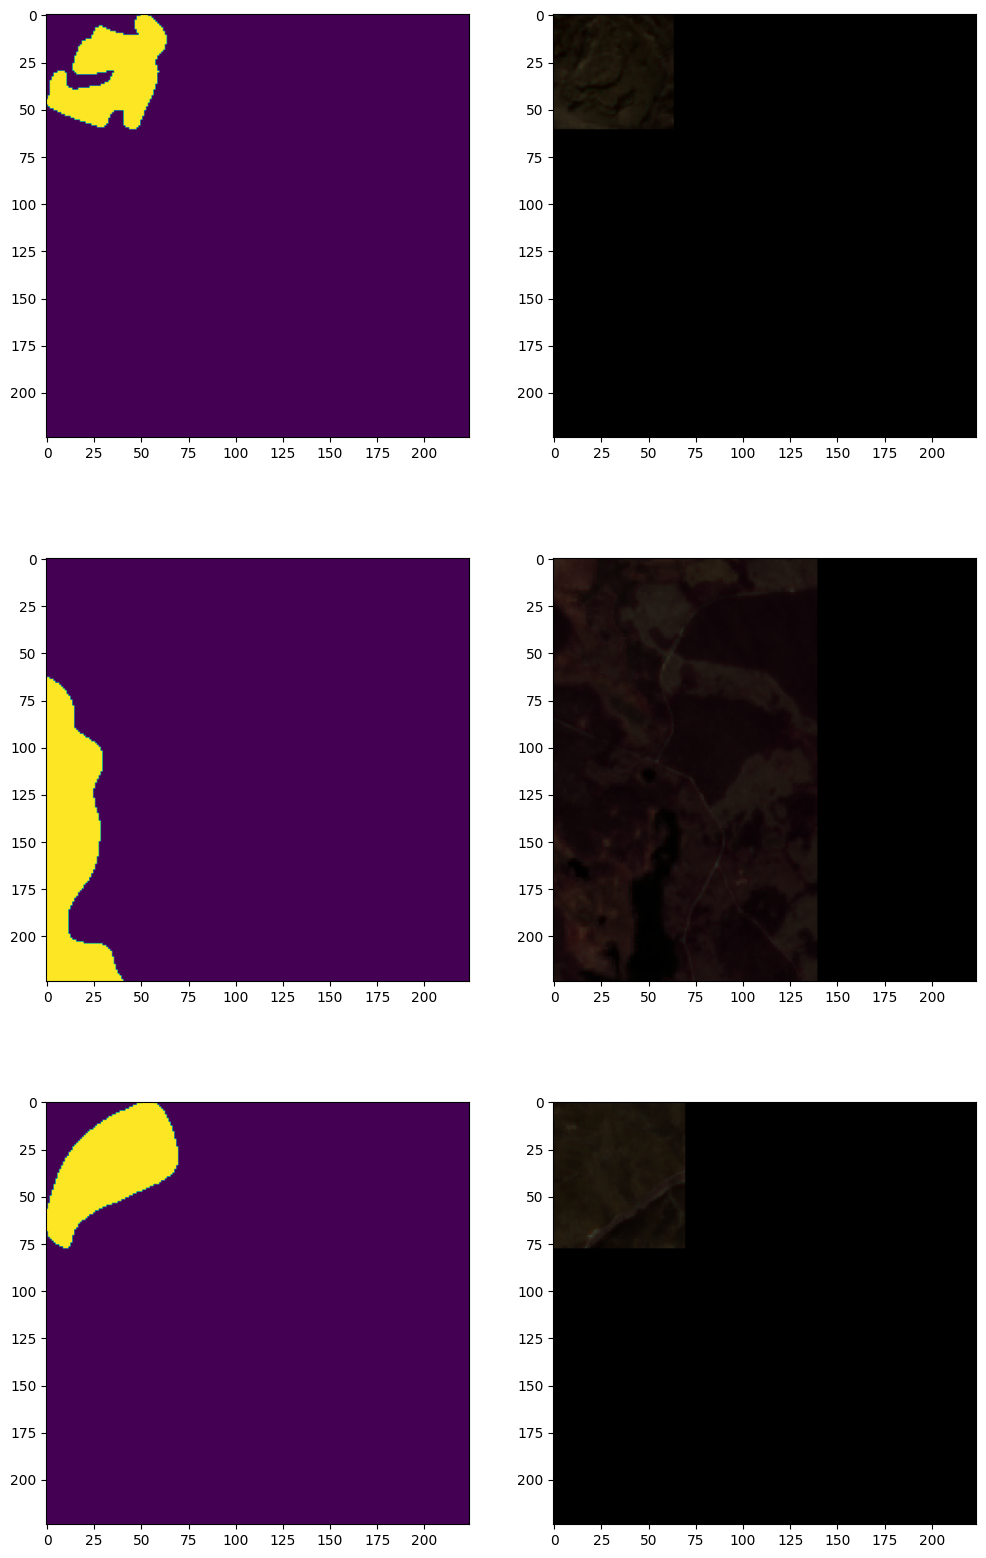

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(12, 20))

axes[0][0].imshow(dataset['validation'][0]['burned_mask']*255)
axes[0][1].imshow((dataset['validation'][0]['S2A'][3:0:-1]*255).astype('int').transpose(1, 2, 0))

axes[1][0].imshow(dataset['validation'][16]['burned_mask']*255)
axes[1][1].imshow((dataset['validation'][16]['S2A'][3:0:-1]*255).astype('int').transpose(1, 2, 0))

axes[2][0].imshow(dataset['validation'][789]['burned_mask']*255)
axes[2][1].imshow((dataset['validation'][789]['S2A'][3:0:-1]*255).astype('int').transpose(1, 2, 0))

plt.show()

## Train using huggingface library

For this tutorial, we are going to use Sentinel 1 GRD Ascending data (bands VV, VH, (VV - VH) / (VV + VH)) as an input RGB image.

First we load an Image Processor, since we only have 2 classes (0 for background and 1 for wildfire) we need to use do_reduce_labels=True, as suggested by the docs. We are not going to use any image augmentation.

In [6]:
from transformers import AutoImageProcessor
image_processor = AutoImageProcessor.from_pretrained('nvidia/mit-b0', do_reduce_labels=True)

In [7]:
def _transforms(example_batch):
    # print(example_batch['S1_GRD_A'][0])
    # Convert S1A into PIL Image objects
    images = [np.asarray(x)[3:0:-1].astype('int') for x in example_batch['S2A']]
    labels = [np.asarray(x) for x in example_batch['burned_mask']]
    inputs = image_processor(images, labels)
    return inputs

train_ds = dataset['train']
val_ds = dataset['validation']
test_ds = dataset['test']

val_ds.set_transform(_transforms)
train_ds.set_transform(_transforms)
test_ds.set_transform(_transforms)

In [8]:
import evaluate

metric = evaluate.load("mean_iou")

id2label = {0: 'wildfire'}
label2id = {'wildfire': 0}

In [9]:
import numpy as np
import torch
from torch import nn

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if isinstance(value, np.ndarray):
                metrics[key] = value.tolist()
        return metrics

In [10]:
from transformers import AutoModelForSemanticSegmentation, TrainingArguments, Trainer

model = AutoModelForSemanticSegmentation.from_pretrained("nvidia/mit-b0", id2label=id2label, label2id=label2id)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
training_args = TrainingArguments(
    output_dir='segformer-b0-scene-parse-150',
    learning_rate=6e-5,
    num_train_epochs=50,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    save_total_limit=3,
    eval_strategy='steps',
    save_strategy='steps',
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    remove_unused_columns=False,
    
    # turnoff wandb
    report_to='none',
    
    # train on 1 batch
    max_steps=1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

max_steps is given, it will override any value given in num_train_epochs
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


TrainOutput(global_step=1, training_loss=0.19473744928836823, metrics={'train_runtime': 0.8294, 'train_samples_per_second': 2.411, 'train_steps_per_second': 1.206, 'total_flos': 35053485686784.0, 'train_loss': 0.19473744928836823, 'epoch': 6.40450877417702e-05})

## Train using PyTorch

In [12]:
# Reload the dataset
dataset = load_dataset('AUA-Informatics-Lab/eo4wildfires')
dataset.set_format('torch')

README.md:   0%|          | 0.00/3.96k [00:00<?, ?B/s]

Loading dataset shards:   0%|          | 0/32 [00:00<?, ?it/s]

In [13]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # Change this to reflect your model input
    imgs = np.asarray([np.asarray(x['S2A'])[3:0:-1].astype('int') for x in batch])
    labels = np.asarray([np.asarray(x['burned_mask']) for x in batch])
    
    return torch.from_numpy(imgs), torch.from_numpy(labels)


batch_size = 4

train_loader = DataLoader(dataset['train'], batch_size=batch_size, collate_fn=collate_fn)
val_loader = DataLoader(dataset['validation'], batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(dataset['test'], batch_size=batch_size, collate_fn=collate_fn)

In [14]:
# Define loss and optimizer
loss_fn = ''
optimizer = ''

# Standard PyTorch training loop 
for i, data in enumerate(train_loader):
    inputs, labels = data
    print(inputs, labels)
    break
    
    optimizer.zero_grad()
    
    # Pass through the model
    outputs = model(inputs)

    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0